In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
predictions = pd.read_parquet('data/exp-6-row-locks/predictions.parquet')
in_lock_sequences = pd.read_parquet('data/exp-6-row-locks/in_lock_sequences.parquet')

In [44]:
VARIABLES = ['gt_pageid', 'pred_pageid', 'horizon_position', 'in_lock_sequences_id', 'gt_table', 'pred_table', 'horizon']

In [3]:
predictions.head()

,in_lock_sequences_id,model,data,train_data_percent_used,epochs,batch_size,learning_rate,seq_length,test_split,val_split,...,token_length_seq,lstm_pe,naive_baseline,disable_cache,model_weights,gt_table,gt_pageid,pred_table,pred_pageid,horizon_position
0,1,transformer,data/fixed/row_locks.csv,1.0,30,32,0.001,50,0.3,0.0,...,True,False,False,False,results/fixed/exp-6-row-locks/char__transforme...,orderline,65381,orderline,65381.0,1
1,2,transformer,data/fixed/row_locks.csv,1.0,30,32,0.001,50,0.3,0.0,...,True,False,False,False,results/fixed/exp-6-row-locks/char__transforme...,stock,2531,stock,37711.0,1
2,3,transformer,data/fixed/row_locks.csv,1.0,30,32,0.001,50,0.3,0.0,...,True,False,False,False,results/fixed/exp-6-row-locks/char__transforme...,orderline,65381,orderline,65381.0,1
3,4,transformer,data/fixed/row_locks.csv,1.0,30,32,0.001,50,0.3,0.0,...,True,False,False,False,results/fixed/exp-6-row-locks/char__transforme...,stock,77377,stock,21111.0,1
4,5,transformer,data/fixed/row_locks.csv,1.0,30,32,0.001,50,0.3,0.0,...,True,False,False,False,results/fixed/exp-6-row-locks/char__transforme...,stock,77377,stock,21111.0,1


In [4]:
in_lock_sequences.head()

,in_lock_sequences,in_lock_sequences_id
0,customer 5 4 9 1 8 history 6 2 9 1 warehouse 4...,1
1,history 6 2 9 1 warehouse 4 district 4 custome...,2
2,warehouse 4 district 4 customer 3 9 1 3 8 hist...,3
3,district 4 customer 3 9 1 3 8 history 6 2 9 1 ...,4
4,customer 3 9 1 3 8 history 6 2 9 1 district 5 ...,5


---

## Data Sanity Checks

In [5]:
predictions.describe()

,in_lock_sequences_id,train_data_percent_used,epochs,batch_size,learning_rate,seq_length,test_split,val_split,vocab_size,patience,horizon,gt_pageid,pred_pageid,horizon_position
count,8.005883e+07,80058830.0,80058830.0,80058830.0,8.005883e+07,80058830.0,8.005883e+07,80058830.0,80058830.0,80058830.0,80058830.0,8.005883e+07,8.004642e+07,80058830.0
mean,3.622722e+05,1.0,30.0,32.0,1.000000e-03,50.0,3.000000e-01,0.0,900.0,5.0,3.0,4.946564e+04,1.725425e+15,2.0
std,2.104680e+05,0.0,0.0,0.0,2.385245e-18,0.0,3.241851e-14,0.0,0.0,0.0,1.0,2.659063e+04,1.036102e+19,1.0
min,1.000000e+00,1.0,30.0,32.0,1.000000e-03,50.0,3.000000e-01,0.0,900.0,5.0,1.0,1.000000e+00,0.000000e+00,1.0
25%,1.803920e+05,1.0,30.0,32.0,1.000000e-03,50.0,3.000000e-01,0.0,900.0,5.0,2.0,2.741500e+04,3.857000e+03,1.0
50%,3.611360e+05,1.0,30.0,32.0,1.000000e-03,50.0,3.000000e-01,0.0,900.0,5.0,3.0,6.494600e+04,6.359700e+04,2.0
75%,5.445760e+05,1.0,30.0,32.0,1.000000e-03,50.0,3.000000e-01,0.0,900.0,5.0,4.0,6.687300e+04,6.627800e+04,3.0
max,7.293320e+05,1.0,30.0,32.0,1.000000e-03,50.0,3.000000e-01,0.0,900.0,5.0,4.0,9.091000e+04,6.845867e+22,4.0


### Lets see how many groups of predicitons exist
There should be 40, which is 10 repitions by 4 horizons

In [6]:
unique_groups = predictions.drop(columns=VARIABLES).drop_duplicates()

In [7]:
unique_groups.nunique()

model                       1
data                        1
train_data_percent_used     1
epochs                      1
batch_size                  1
learning_rate               1
seq_length                  1
test_split                  1
val_split                   1
vocab_size                  1
tokenization                1
patience                    1
results_dir                 1
experiment_name             1
horizon                     4
shuffle                     1
add_start_end_tokens        1
add_row_id                  1
add_label_tokens            1
disable_train_shuffle       1
early_stopping              1
remove_system_tables        1
token_length_seq            1
lstm_pe                     1
naive_baseline              1
disable_cache               1
model_weights              40
dtype: int64

### Lets now check the number of rows for increasing number of horizons
This should be equal to a multiple of the number of rows when `horizon==1` (since each horzion positions is its own row)

In [8]:
num_of_pred = predictions[predictions['horizon'] == 1].shape[0]
num_of_pred

8005890

In [9]:
for horizon in predictions['horizon'].unique():
    assert num_of_pred * horizon == predictions[predictions['horizon'] == horizon].shape[0], (
        f"Number of predictions for horizon {horizon} is not correct.",
        f"Expected: {num_of_pred * horizon}",
        f"Actual: {predictions[predictions['horizon'] == horizon].shape[0]}",
        f"Difference: {num_of_pred * horizon - predictions[predictions['horizon'] == horizon].shape[0]}"
    )

AssertionError: ('Number of predictions for horizon 4 is not correct.', 'Expected: 32023560', 'Actual: 32023520', 'Difference: 40')

While I expected this assertion to hold, there may be a side-effect of sequence creation which larger horizons that I am not accounting for.

For example, depending if there is any overlap between sequence, it may account for there being less than exactly `num_of_pred * horizon`.

In [10]:
horizon_4_unqiue = predictions[predictions['horizon'] == 4]['model_weights'].groupby(predictions['model_weights'])
horizon_4_unqiue.count()

model_weights
results/fixed/exp-6-row-locks/char__transformer_20250115_155211_4a9914df-44e7-4709-b93f-2899a05761e4/model.keras    3202352
results/fixed/exp-6-row-locks/char__transformer_20250115_164639_11d92135-a44b-4015-9a03-3e37c93283f8/model.keras    3202352
results/fixed/exp-6-row-locks/char__transformer_20250115_173807_5849bb81-9b78-440c-a791-a0da558ef007/model.keras    3202352
results/fixed/exp-6-row-locks/char__transformer_20250115_183129_be0f75cf-94dc-4ed3-b3af-5843eac87069/model.keras    3202352
results/fixed/exp-6-row-locks/char__transformer_20250115_192614_f92ff2c9-4f61-464c-a2ce-8872fa2d0fdb/model.keras    3202352
results/fixed/exp-6-row-locks/char__transformer_20250115_202048_efb07517-a3b6-42d6-87ca-ede888c20210/model.keras    3202352
results/fixed/exp-6-row-locks/char__transformer_20250115_211559_dc0328e3-f880-49f2-a274-42326e1c06d5/model.keras    3202352
results/fixed/exp-6-row-locks/char__transformer_20250115_220832_37086c9c-1b81-463f-b306-6beb9cac68fd/model.keras    32

In [11]:
horizon_4_unqiue.count().sum() == 32023520

True

Above looks at how many rows there are for each repition of `horizon==4`. They are all the same, so this means we have 4 less rows for each of the 10 reps.

This equates to only 1 less test example (since we split by horizon position, thus 4 less rows means 1 less lock prediciton at `horizon==4`)

### Lets look at the distribution of pageid values

In [12]:
predictions['pred_pageid'].min(), predictions['pred_pageid'].max(), predictions['pred_pageid'].mean(), predictions['pred_pageid'].std()

(0.0, 6.845866623866862e+22, 1725424805245443.2, 1.0361023799303481e+19)

Thats a very wide range of predicted page_ids. Lets checkout the histogram.

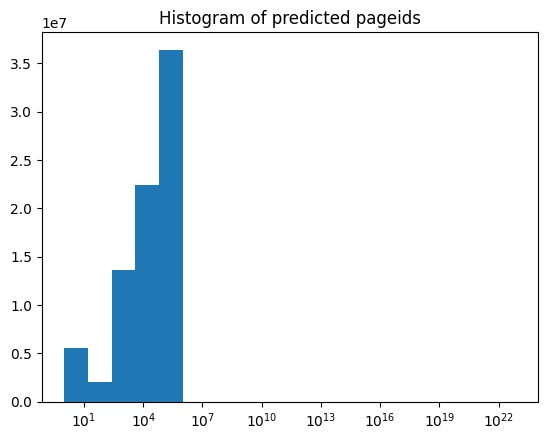

(8858, (80058830, 33))

In [15]:
max_log10 = np.log10(predictions['pred_pageid'].max())
plt.hist(predictions['pred_pageid'], bins=np.logspace(0, max_log10, 20))
plt.xscale('log')
plt.title('Histogram of predicted pageids')
plt.show()

(predictions['pred_pageid'] > 10e4).sum(), predictions.shape

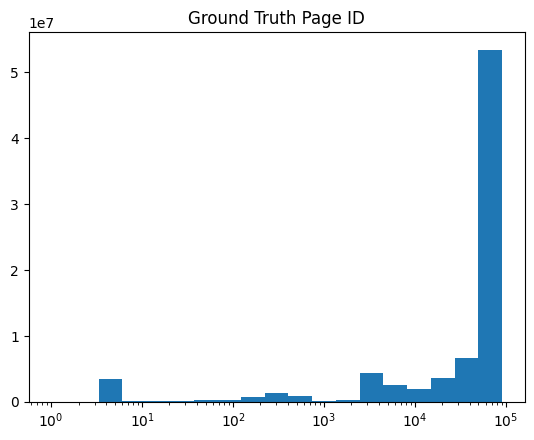

(0, (80058830, 33))

In [23]:
max_log10 = np.log10(predictions['gt_pageid'].max())
plt.hist(predictions['gt_pageid'], bins=np.logspace(0, max_log10, 20))
plt.xscale('log')
plt.title('Ground Truth Page ID')
plt.show()

(predictions['gt_pageid'] > 10e4).sum(), predictions.shape


Okay everything, looks normal. We just have a few outliers in the prediction, but the ground truth looks good.

## Global vs. Local Analysis

In [99]:
def calc_corret_by_table(preds):
    stats = []

    for horizon in preds['horizon'].unique():
        horizon_preds = preds[(preds['horizon'] == horizon)][VARIABLES]
        table_names = horizon_preds['gt_table'].unique()

        for table in table_names:
            table_preds = horizon_preds[horizon_preds['gt_table'] == table]
            # Calculate the number of correct predictions (i.e., gt_pageid == pred_pageid and gt_table == pred_table)
            correct_preds = table_preds[(table_preds['gt_pageid'] == table_preds['pred_pageid']) & (table_preds['gt_table'] == table_preds['pred_table'])]
            percent_correct = correct_preds.shape[0] / table_preds.shape[0] if table_preds.shape[0] > 0 else 0
            stats.append({
                'table': table,
                'horizon': horizon,
                'num_correct': correct_preds.shape[0],
                'num_total': table_preds.shape[0],
                'percent_correct': percent_correct
        })
    return pd.DataFrame(stats)

In [91]:
stats_df = calc_corret_by_table(predictions)

In [92]:
stats_df[stats_df['horizon'] == 1].sort_values('percent_correct', ascending=False)

,table,horizon,num_correct,num_total,percent_correct
0,orderline,1,3633578,4377420,0.830073
5,district,1,37482,122960,0.304831
7,warehouse,1,17129,61420,0.278883
6,history,1,2318,167120,0.013870
3,neworder,1,968,279700,0.003461
2,orders,1,213,349140,0.000610
4,customer,1,65,419910,0.000155
1,stock,1,39,2228220,0.000018


In [93]:
per_table_accuracies = stats_df.pivot(index='table', columns='horizon', values='percent_correct').sort_values(by='table')
per_table_accuracies

horizon,1,2,3,4
table,,,,
customer,0.000155,0.000063,0.000060,0.000029
district,0.304831,0.198696,0.154803,0.139798
history,0.013870,0.171304,0.068230,0.046577
neworder,0.003461,0.001325,0.000640,0.000502
orderline,0.830073,0.802507,0.756263,0.624860
orders,0.000610,0.000528,0.000272,0.000194
stock,0.000018,0.000020,0.000014,0.000017
warehouse,0.278883,0.553775,0.368910,0.202675


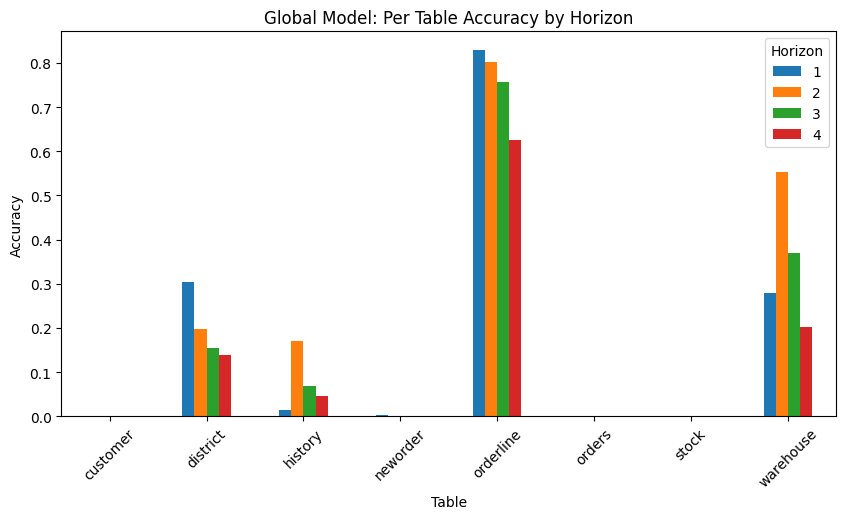

In [94]:
per_table_accuracies.sort_values(by='table').plot(kind='bar', figsize=(10,5), title='Global Model: Per Table Accuracy by Horizon')
plt.xlabel('Table')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend(title='Horizon')
plt.show()

### Now lets see the Local models
I.e., the models trained on each dataset table seperately

In [88]:
predictions_row_sep = pd.read_parquet('data/row_sep/exp-11-row-locks/predictions.parquet')

In [89]:
predictions_row_sep.head()

,in_lock_sequences_id,model,data,train_data_percent_used,epochs,batch_size,learning_rate,seq_length,test_split,val_split,...,token_length_seq,lstm_pe,naive_baseline,disable_cache,args_file,horizon_position,gt_table,gt_pageid,pred_table,pred_pageid
0,1,transformer,data/fixed/row_sep/WAREHOUSE.csv,1.0,30,32,0.001,50,0.3,0.0,...,True,False,False,False,None,1,warehouse,4,warehouse,4.0
1,1,transformer,data/fixed/row_sep/WAREHOUSE.csv,1.0,30,32,0.001,50,0.3,0.0,...,True,False,False,False,None,2,warehouse,4,warehouse,4.0
2,1,transformer,data/fixed/row_sep/WAREHOUSE.csv,1.0,30,32,0.001,50,0.3,0.0,...,True,False,False,False,None,3,warehouse,4,warehouse,4.0
3,1,transformer,data/fixed/row_sep/WAREHOUSE.csv,1.0,30,32,0.001,50,0.3,0.0,...,True,False,False,False,None,4,warehouse,4,warehouse,4.0
4,1,transformer,data/fixed/row_sep/WAREHOUSE.csv,1.0,30,32,0.001,50,0.3,0.0,...,True,False,False,False,None,1,warehouse,4,warehouse,4.0


In [95]:
stats_local_df = calc_corret_by_table(predictions_row_sep)

In [96]:
stats_local_df[stats_local_df['horizon'] == 1].sort_values('percent_correct', ascending=False)

,table,horizon,num_correct,num_total,percent_correct
20,warehouse,1,195800,195800,1.000000
21,history,1,192269,195840,0.981766
22,orderline,1,3727266,4072510,0.915226
16,district,1,159180,393530,0.404493
19,neworder,1,116321,390960,0.297527
23,orders,1,26426,390960,0.067593
18,customer,1,95,389110,0.000244
17,stock,1,44,1976930,0.000022


In [97]:
per_table_accuracies_local = stats_local_df.pivot(index='table', columns='horizon', values='percent_correct').sort_values(by='table')
per_table_accuracies_local

horizon,1,2,3,4
table,,,,
customer,0.000244,0.000233,0.000182,0.000184
district,0.404493,0.404505,0.404503,0.404503
history,0.981766,0.972641,0.962257,0.952824
neworder,0.297527,0.253516,0.219841,0.190471
orderline,0.915226,0.877352,0.840473,0.804028
orders,0.067593,0.100582,0.105672,0.089879
stock,0.000022,0.000020,0.000023,0.000017
warehouse,1.000000,1.000000,1.000000,1.000000


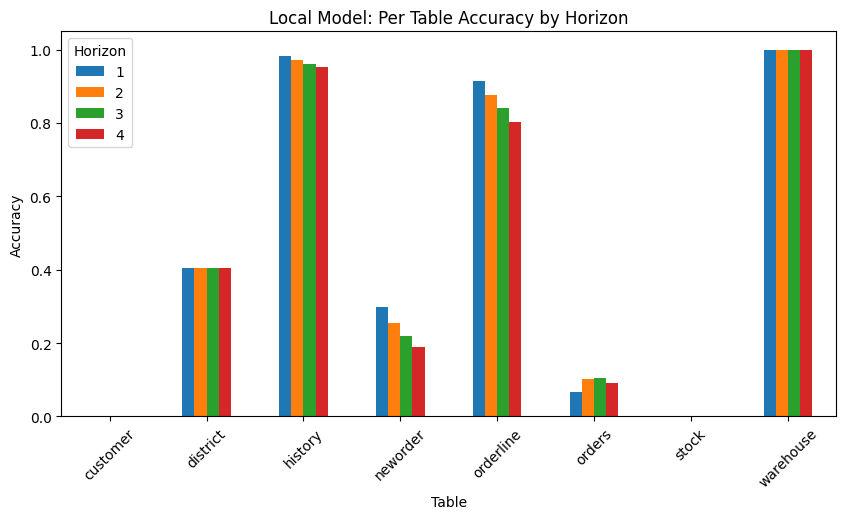

In [98]:
per_table_accuracies_local.sort_values(by='table').plot(kind='bar', figsize=(10,5), title='Local Model: Per Table Accuracy by Horizon')
plt.xlabel('Table')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend(title='Horizon')
plt.show()

TODO: Validate the per-table accuracies. Looking at the local model, I see some inconsistencies between these values from the parquet file and the ones calculated from the `src/transform.py` script.